<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/kaggle-wheat-Detection/Global_Wheat_Detection_Faster_R_CNN_Train_(torchvision).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Wheat Detection
https://www.kaggle.com/c/global-wheat-detection/overview

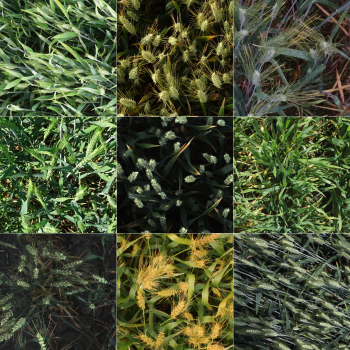

Files
* train.csv - the training data
* sample_submission.csv - a sample submission file in the correct format
* train.zip - training images
* test.zip - test images

Columns
* image_id - the unique image ID
* width, height - the width and height of the images
* bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
* etc.



# 데이터 다운로드

In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [3]:
!kaggle competitions download -c global-wheat-detection

 98% 593M/607M [00:02<00:00, 220MB/s]
100% 607M/607M [00:02<00:00, 251MB/s]


In [ ]:
!unzip global-wheat-detection

## 데이터 탐색

In [5]:
import glob

imgs = os.listdir('train')
# 이미지 개수 확인
len(imgs)

3422

In [6]:
# 확장자명 제거
imgs = [img.split('.')[0] for img in imgs]
len(imgs)

3422

In [7]:
import pandas as pd

train_df = pd.read_csv('train.csv')

In [8]:
train_df.head(10)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
5,b6ab77fd7,1024,1024,"[569.0, 382.0, 119.0, 111.0]",usask_1
6,b6ab77fd7,1024,1024,"[52.0, 602.0, 82.0, 45.0]",usask_1
7,b6ab77fd7,1024,1024,"[627.0, 302.0, 122.0, 75.0]",usask_1
8,b6ab77fd7,1024,1024,"[412.0, 367.0, 68.0, 82.0]",usask_1
9,b6ab77fd7,1024,1024,"[953.0, 220.0, 56.0, 103.0]",usask_1


In [9]:
train_df.source.value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [10]:
# 딕셔너리에 label명을 인코딩해서 저장
label_encode = {}
for i, label in enumerate(list(train_df.source.value_counts().index)):
  label_encode[label] = i+1

label_encode

{'arvalis_1': 2,
 'arvalis_2': 6,
 'arvalis_3': 4,
 'ethz_1': 1,
 'inrae_1': 7,
 'rres_1': 3,
 'usask_1': 5}

# 학습용, 검증용 데이터 분리

In [11]:
image_ids = sorted(list(train_df.image_id.value_counts().index))

In [12]:
!mkdir tr_label; mkdir val_label

In [13]:
!mkdir tr_images; mkdir val_images

In [14]:
# 전체 이미지 3422장 중에서 annotate된 이미지 수
len(image_ids)

3373

In [15]:
# annotation이 없는 이미지 목록
no_label_imgs = set(imgs) - set(image_ids)
no_label_imgs

{'00b5c6764',
 '0cf7ef43d',
 '0e7832f0b',
 '155c440e8',
 '1a9792bfc',
 '2d80f9c49',
 '2e6c333a7',
 '3116768f0',
 '39a0e5556',
 '45fddc611',
 '46c6a747a',
 '49e40c7a4',
 '526d737d1',
 '581eaf87b',
 '5901a73fe',
 '5cbd092f9',
 '6584c18c0',
 '65d0b13aa',
 '69352f3fa',
 '7e1caf1f7',
 '83a94fc79',
 '8425a537b',
 '8a5cb62db',
 '8de789df8',
 '91d4e3750',
 '952e7d15c',
 '9e21e7969',
 'a3ce975cd',
 'ab20ec355',
 'b45c5294d',
 'c18c32da0',
 'c74ca81bd',
 'ccb3892c1',
 'cf1d2f504',
 'cfc9040ca',
 'd771bb084',
 'd7e657453',
 'd83808467',
 'dd5d2fa9e',
 'de2a3cf37',
 'dec23c826',
 'e01ad95cf',
 'e4ec17f9b',
 'ec196d18a',
 'ed00a614d',
 'f2a6804d2',
 'f530a5d4b',
 'f9cafa47f',
 'ffbb9c623'}

In [16]:
from sklearn.model_selection import train_test_split

tr_imgs, val_imgs = train_test_split(image_ids, test_size = 0.15, random_state = 42)
len(tr_imgs), len(val_imgs)

(2867, 506)

In [17]:
import shutil

# 학습용 이미지 검증용 이미지 분리

for img in tr_imgs:
  src = os.path.join('train', img + '.jpg')
  dst = os.path.join('tr_images', img + '.jpg')
  shutil.move(src, dst)

for img in val_imgs:
  src = os.path.join('train', img + '.jpg')
  dst = os.path.join('val_images', img + '.jpg')
  shutil.move(src, dst)

# annotation 파일 생성 (txt format)

In [18]:
for _, id, w, h, bbox, source in (train_df[ train_df['image_id'] == tr_imgs[0]]).itertuples():
  print(id, w, h, bbox, source)


ffc870198 1024 1024 [447.0, 976.0, 78.0, 48.0] usask_1
ffc870198 1024 1024 [18.0, 141.0, 218.0, 126.0] usask_1
ffc870198 1024 1024 [704.0, 687.0, 79.0, 78.0] usask_1
ffc870198 1024 1024 [943.0, 842.0, 81.0, 143.0] usask_1
ffc870198 1024 1024 [361.0, 222.0, 178.0, 70.0] usask_1
ffc870198 1024 1024 [373.0, 34.0, 103.0, 68.0] usask_1
ffc870198 1024 1024 [1010.0, 0.0, 14.0, 42.0] usask_1
ffc870198 1024 1024 [585.0, 906.0, 115.0, 45.0] usask_1
ffc870198 1024 1024 [0.0, 906.0, 68.0, 88.0] usask_1
ffc870198 1024 1024 [309.0, 323.0, 110.0, 103.0] usask_1
ffc870198 1024 1024 [976.0, 336.0, 48.0, 90.0] usask_1
ffc870198 1024 1024 [855.0, 0.0, 93.0, 55.0] usask_1
ffc870198 1024 1024 [509.0, 0.0, 105.0, 124.0] usask_1
ffc870198 1024 1024 [578.0, 710.0, 103.0, 129.0] usask_1
ffc870198 1024 1024 [0.0, 0.0, 126.0, 42.0] usask_1
ffc870198 1024 1024 [166.0, 816.0, 244.0, 77.0] usask_1
ffc870198 1024 1024 [498.0, 640.0, 150.0, 92.0] usask_1
ffc870198 1024 1024 [253.0, 561.0, 172.0, 68.0] usask_1
ffc8701

In [19]:
# bbox 문자열을 읽고 실수형 bbox좌표를 반환하는 함수 (pascal VOC 포맷)
def make_bbox(bbox):
  xmin, ymin, box_width, box_height = [float(s.strip('[').strip(']')) for s in bbox.split(',')]
  xmax = xmin + box_width
  ymax = ymin + box_height
  return float(xmin), float(ymin), float(xmax), float(ymax)

# 데이터프레임에서 img_id_list에 있는 annotation만 읽어 
# 각 이미지 id의 txt label 파일로 만드는 함수
def csv_to_txt(df, img_id_list, output_dir):
  for img in img_id_list:
    output_txt_file = os.path.join(output_dir, img + '.txt')

    with open(output_txt_file, 'w') as output_fpointer:
      for _, id, w, h, bbox, label in (df[df['image_id'] == img]).itertuples():
        xmin, ymin, xmax, ymax = make_bbox(bbox)

        # 만약 좌표중에 0보다 작은 값이 있으면 해당 xml파일 변환 종료
        if (xmin < 0) or (ymin < 0) or (xmax < 0) or (ymax < 0):
          break
        
        #변환된 yolo 좌표를 object별로 출력 text 파일에 write
        value_str = ('{0} {1} {2} {3} {4}').format(label, xmin, ymin, xmax, ymax)
        output_fpointer.write(value_str + '\n')

In [20]:
# 학습용 annotation, 검증용 annotation 생성
csv_to_txt(train_df, val_imgs, 'val_label')
csv_to_txt(train_df, tr_imgs, 'tr_label')

In [21]:
len(os.listdir('tr_images')), len(os.listdir('tr_label')), len(os.listdir('val_images')), len(os.listdir('val_label'))

(2867, 2867, 506, 506)

# 데이터셋, 데이터 로더 생성

In [22]:
import torch

# 이미지의 annotation txt를 읽어 target 딕셔너리를 반환하는 함수
def generate_target(txt):
  with open(txt) as f:
    lines = f.readlines()

    boxes = []
    labels = []

    for line in lines:
      line = line.strip('\n')
      label = line.split(' ')[0]
      label = label_encode[label]
      box = list(map(float,line.split(' ')[1:]))
      labels.append(label)
      boxes.append(box)
    
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    labels = torch.as_tensor(labels, dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return target


In [23]:
generate_target('/content/val_label/00333207f.txt')

{'boxes': tensor([[   0.,  654.,   37.,  765.],
         [   0.,  817.,  135.,  915.],
         [   0.,  192.,   22.,  273.],
         [   4.,  342.,   67.,  380.],
         [  82.,  334.,  164.,  415.],
         [  30.,  296.,   78.,  345.],
         [ 176.,  316.,  246.,  370.],
         [ 176.,  126.,  245.,  177.],
         [ 203.,   38.,  245.,  123.],
         [   3.,  142.,   92.,  200.],
         [ 236.,    0.,  296.,   25.],
         [ 329.,    0.,  404.,   57.],
         [ 796.,    0.,  865.,   96.],
         [ 659.,   24.,  718.,  114.],
         [ 540.,   81.,  680.,  161.],
         [ 233.,  152.,  322.,  203.],
         [ 422.,  159.,  480.,  209.],
         [ 462.,  153.,  667.,  217.],
         [ 468.,  210.,  576.,  263.],
         [ 417.,  235.,  553.,  323.],
         [ 287.,  257.,  343.,  308.],
         [ 283.,  322.,  400.,  398.],
         [ 393.,  329.,  567.,  429.],
         [ 606.,  346.,  653.,  403.],
         [ 611.,  286.,  681.,  342.],
         [ 718.,

In [24]:
from PIL import Image
import numpy as np
import time
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

In [25]:
class WheatDataset(Dataset):
  def __init__(self, path, transforms = None):
    self.path = path
    self.imgs = list(sorted(glob.glob(self.path + '/*')))
    self.transforms = transforms

  def __getitem__(self, idx):
    img_path = self.imgs[idx]
    file_label = img_path.split('/')[1][:-3] + 'txt'

    if 'tr' in self.path:
      label_path = os.path.join('tr_label', file_label)
    else:
      label_path = os.path.join('val_label', file_label)

    img = Image.open(img_path).convert('RGB')
    target = generate_target(label_path)

    if self.transforms:
      img, target = self.transforms(img, target)
    
    return img, target
  
  def __len__(self):
    return len(self.imgs)



In [26]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 109578, done.
remote: Counting objects: 100% (1809/1809), done.
remote: Compressing objects: 100% (571/571), done.
remote: Total 109578 (delta 1635), reused 1322 (delta 1229), pack-reused 107769
Receiving objects: 100% (109578/109578), 210.93 MiB | 40.58 MiB/s, done.
Resolving deltas: 100% (94681/94681), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [27]:
import transforms as T

def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    # 학습시 50% 확률로 학습 영상을 좌우 반전 변환
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [28]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [29]:
dataset = WheatDataset('tr_images', get_transform(train = True))
dataset_test = WheatDataset('val_images', get_transform(train = False))

In [30]:
next(iter(dataset))

(tensor([[[0.3647, 0.3412, 0.3216,  ..., 0.3529, 0.3647, 0.3608],
          [0.3608, 0.3490, 0.3216,  ..., 0.3804, 0.3725, 0.3529],
          [0.3569, 0.3490, 0.3333,  ..., 0.3804, 0.3647, 0.3451],
          ...,
          [0.2314, 0.2314, 0.2235,  ..., 0.3608, 0.3647, 0.3686],
          [0.2392, 0.2353, 0.2196,  ..., 0.3529, 0.3529, 0.3529],
          [0.2392, 0.2353, 0.2196,  ..., 0.3412, 0.3373, 0.3333]],
 
         [[0.3412, 0.3294, 0.3098,  ..., 0.4471, 0.4588, 0.4510],
          [0.3373, 0.3255, 0.3098,  ..., 0.4745, 0.4588, 0.4353],
          [0.3333, 0.3255, 0.3098,  ..., 0.4706, 0.4431, 0.4235],
          ...,
          [0.2039, 0.2000, 0.2000,  ..., 0.4000, 0.4039, 0.4078],
          [0.2118, 0.2039, 0.1961,  ..., 0.3922, 0.3922, 0.3922],
          [0.2157, 0.2118, 0.1961,  ..., 0.3804, 0.3765, 0.3725]],
 
         [[0.2784, 0.2627, 0.2510,  ..., 0.3843, 0.4078, 0.4196],
          [0.2745, 0.2627, 0.2510,  ..., 0.4118, 0.4118, 0.4000],
          [0.2784, 0.2706, 0.2549,  ...,

In [31]:
# 데이터를 배치 단위로 불러옰수 있게 Dataloader함수 사용
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle = True, num_workers = 4,
    collate_fn = collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size = 1, shuffle = False, num_workers = 4,
    collate_fn = collate_fn
)

In [32]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead')
  device = torch.device('cpu')

There are 1 GPU(s) available
We will use the GPU: Tesla T4


In [33]:
label_encode

{'arvalis_1': 2,
 'arvalis_2': 6,
 'arvalis_3': 4,
 'ethz_1': 1,
 'inrae_1': 7,
 'rres_1': 3,
 'usask_1': 5}

# 모델 불러오기

In [34]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):

  # backbone : ResNet50, COCO 2017 Data으로 사전학습된 모델을 가져온다.
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
  # classifier를 위한 input feature의 크기를 얻는다.
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # 사전학습된 모델의 head를 새로운 head로 교체한다.
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [35]:
model = get_model(8)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## 하이퍼 파라미터 설정

In [36]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.001,
                            momentum = 0.9, weight_decay = 0.0005)

In [37]:
# 3 epoch마다 학습률을 10배 감소시키는 learning rate scheduler 정의
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size = 3,
                                               gamma = 0.1)

In [38]:
model.train()
imgs , annots = next(iter(data_loader))
imgs = list(img.to(device) for img in imgs)
annots = [{k: v.to(device) for k, v in t.items()} for t in annots]

In [39]:
loss_dict = model(imgs, annots)
loss_dict

{'loss_box_reg': tensor(0.4305, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_classifier': tensor(1.8190, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(3.2045, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1253, device='cuda:0', grad_fn=<DivBackward0>)}

In [40]:
# torchvision helper function을 사용하지 않는 학습

print('-----------------Train Start-----------------')
for epoch in range(num_epochs):
  start = time.time()
  model.train()

  epoch_loss = 0
  for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k:v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    epoch_loss += losses

  lr_scheduler.step()
  
  print(f'epoch: {epoch + 1}, Loss: {epoch_loss}, time: {time.time() - start}')
  

-----------------Train Start-----------------
epoch: 1, Loss: 1564.917236328125, time: 591.9418315887451
epoch: 2, Loss: 1192.7740478515625, time: 599.6566877365112
epoch: 3, Loss: 1128.092041015625, time: 599.976803779602
epoch: 4, Loss: 1050.9759521484375, time: 599.8291141986847
epoch: 5, Loss: 1039.89697265625, time: 599.7843420505524
epoch: 6, Loss: 1036.070556640625, time: 599.9833199977875
epoch: 7, Loss: 1029.69189453125, time: 599.7393288612366
epoch: 8, Loss: 1029.22509765625, time: 599.8134381771088
epoch: 9, Loss: 1027.20263671875, time: 599.8962576389313
epoch: 10, Loss: 1027.2305908203125, time: 599.9322128295898


In [ ]:
# torchvision helper function을 사용한 학습

from torch.optim.lr_scheduler import StepLR
from engine import train_one_epoch, evaluate

print('-----------------Train Start-----------------')
for epoch in range(num_epochs):
  # 한 epoch학습하고 10회씩 순회할때마다 결과 출력
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq = 10)
  # learning rate 업데이트
  lr_scheduler.step()
  # 테스트 데이터에 대해 평가
  evaluate(model, data_loader_test, device = device)

## 모델 파라미터 저장

In [41]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/kaggle global wheat/model_Faster_RCNN_{num_epochs}.pt')

In [42]:
# predict 리스트에서 confidence socre 값이 threshold 이상인 결과만 저장

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)

    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [49]:
import cv2

color_list = [
              (0, 0, 255),
              (255, 0, 0),
              (0, 255, 0),
              (255, 160, 0), # orange
              (255, 0, 255), # magenta
              (0, 255, 255), # aqua
              (255, 255, 0) # yellow
]

# 한 이미지와 annotation을 읽어 bbox를 그리고 이미지를 반환하는 함수
def plot_image_from_output_cv(img, annotation):
  img = img.permute(1, 2, 0)
  img = img.to('cpu')
  img2 = np.array(img.numpy() * 255, dtype = np.uint8)
  img_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])

    color = color_list[annotation['labels'][i] - 1]
    # 기존 label encode 딕셔너리 키값을 스왑하여 int값 레이블로 text 레이블 저장
    text = dict(zip(label_encode.values(), label_encode.keys()))[int(annotation['labels'][i])]

    cv2.rectangle(img_bgr, (left, top), (right, bottom), color = color, thickness = 2)
    cv2.putText(img_bgr, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 2)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  return img_rgb

In [44]:
# batch data 하나를 inference하고 결과 출력
with torch.no_grad():
  for imgs, annotations in data_loader_test:
    imgs = list(img.to(device) for img in imgs)

    pred = make_prediction(model, imgs, 0.5)
    print(pred)
    print(len(pred))
    break

[{'boxes': tensor([[1.0737e+00, 8.1522e+02, 1.2477e+02, 8.9752e+02],
        [8.6161e+02, 3.9866e+02, 9.6590e+02, 4.9865e+02],
        [7.8614e+02, 4.6650e-02, 8.6524e+02, 1.1764e+02],
        [2.7240e+02, 9.3454e+02, 3.9850e+02, 1.0108e+03],
        [5.7814e+02, 8.6600e+02, 7.6080e+02, 9.7380e+02],
        [8.4386e+02, 8.4819e+02, 9.9457e+02, 1.0016e+03],
        [3.2750e+02, 0.0000e+00, 4.1645e+02, 5.7539e+01],
        [6.0551e+02, 7.1239e+02, 6.8164e+02, 8.0041e+02],
        [7.0762e+02, 7.6474e+02, 8.1877e+02, 8.2992e+02],
        [2.8207e+02, 4.1519e+02, 3.5421e+02, 5.0354e+02],
        [7.7191e+02, 4.6546e+02, 8.6824e+02, 5.7743e+02],
        [2.4366e+02, 5.2126e+02, 3.2769e+02, 5.9027e+02],
        [3.8680e+02, 3.2360e+02, 5.4433e+02, 4.2079e+02],
        [1.7974e+02, 2.2571e+01, 2.5545e+02, 1.1366e+02],
        [7.0700e+02, 1.8535e+02, 8.1633e+02, 2.6924e+02],
        [5.4058e+02, 8.6017e+01, 6.8617e+02, 1.5587e+02],
        [8.2099e+02, 1.9230e+02, 9.3087e+02, 2.5898e+02],
   

In [45]:
from tqdm import tqdm
labels = []
preds_adj_all = []
annot_all = []

# 전체 테스트 데이터를 배치단위로 결과를 리스트레 저장
for im, annot in tqdm(data_loader_test, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.3)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 506/506 [00:50<00:00, 10.06it/s]


# 테스트 결과 시각화

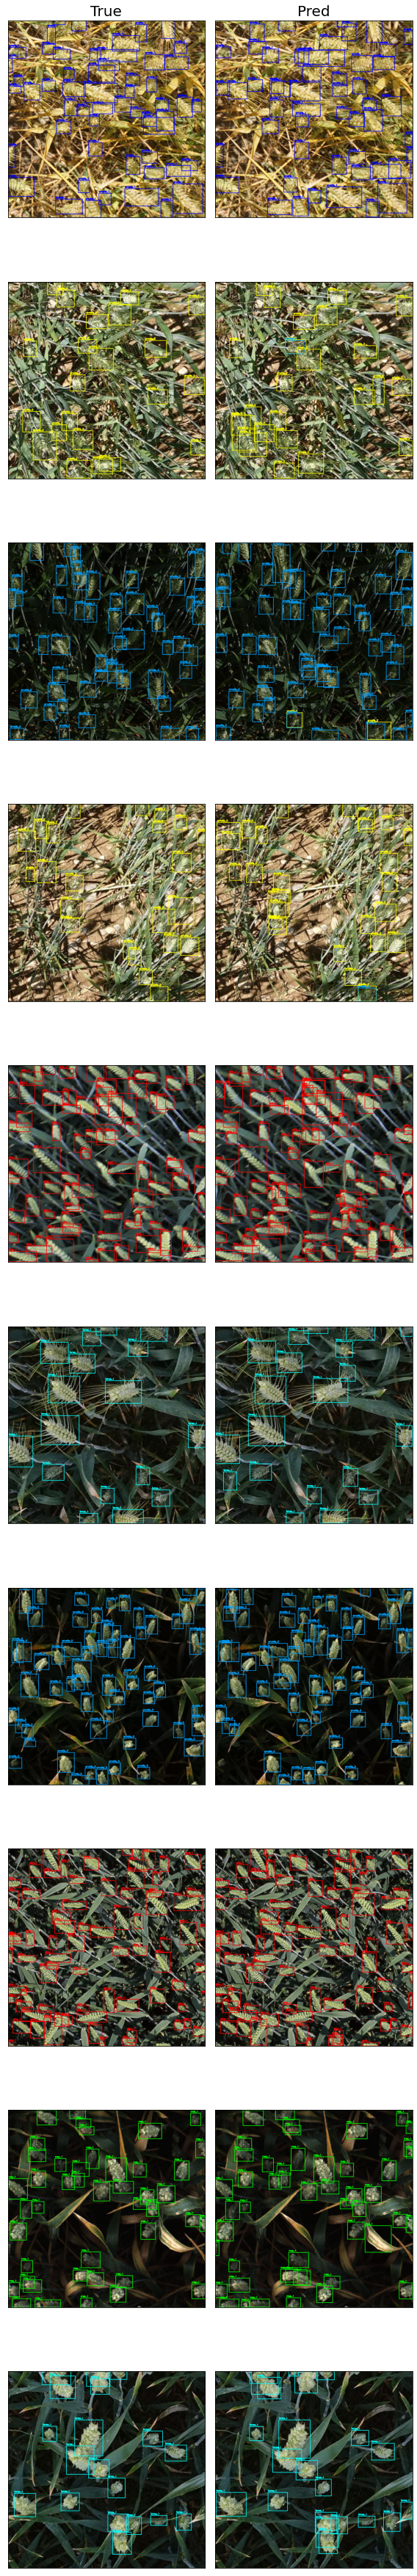

In [56]:
import matplotlib.pyplot as plt

nrows = 10
ncols = 2
fig, axes = plt.subplots(nrows = 10, ncols = 2, figsize = (ncols * 4, nrows * 5))

batch_i = 0
row = 0
img_num = 1
for im, annot in data_loader_test:


  img1 = plot_image_from_output_cv(im[0], annot[0])
  img2 = plot_image_from_output_cv(im[0], preds_adj_all[batch_i][0])
  if batch_i >= 10:
    break
  axes[row, 0].imshow(img1)
  axes[row, 1].imshow(img2)

  row += 1
  img_num += 1

  batch_i += 1
#  if batch_i == 4:
#    break

for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])

colnames = ['True', 'Pred']
for idx, ax in enumerate(axes[0]):
  ax.set_title(colnames[idx], fontdict = {'fontsize' : 20})

plt.tight_layout()
plt.show()